# Model selection and Evaluation

This notebook has code to reproduce the results of the report from Group 54, Deep Learning 2025, project n.16

In [45]:
from scripts.models import *
from scripts.data import GenesDataset, load_standard_hvg, load_scGPT, load_geneaware, load_embeddings
from pathlib import Path
import numpy as np
from scipy.stats import spearmanr, pearsonr
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

10% of the original dataset was held-out for evaluation purpose and model selection

In [46]:
# Load the evaluation datasets
ISOFORM_PATH = Path("/dtu/blackhole/19/221977/train_val_split_data/sc_processed_transcripts_evaluation_set.h5ad") # path to isoform
GENES_PATH = Path("/dtu/blackhole/19/221977/train_val_split_data/sc_processed_genes_evaluation_set.h5ad") # path to gene table
PT_PATH = Path("/dtu/blackhole/19/221977/train_val_split_data/preprocessed_train_3000hvg_test.pt") # preprocessed data, filtering highly variable genes
RESULTS_PATH = Path("/dtu/blackhole/19/221977/Results") # model weight directory

In [9]:
# load the evaluation dataset (10% holdout)
genes_tensor, isoform_proportions, gene_to_iso_map, iso_to_gene_index, isoform_ids = load_geneaware(
    GENES_PATH,
    ISOFORM_PATH,
    seed=42,
    max_samples=None,
    selection_method='top_counts',
    min_counts=0
    )

[data] gene_id_col 'gene_name' not found in genes var; using index instead.


/appl9/python/3.13.8/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/appl9/python/3.13.8/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


[data] isoform_id_col 'transcript_id' not found in isoform var; using index instead.


In [47]:
# Load the dataset with 3000 filtered highly variable genes
standard_hvg_genes_tensor, standard_hvg_isoform_proportions, standard_hvg_gene_to_iso_map, standard_hvg_iso_to_gene_index, standard_hvg_isoform_ids, standard_hvg_gene_ids = load_standard_hvg(
        PT_PATH
    )

## Run Inference

In [5]:
checkpoint_path = RESULTS_PATH / "MLP_vs_GeneAware_MLP" / "MLP_GeneAware_45k" / "MLP_GeneAware_45k_weights_2.pth"
checkpoint = torch.load(checkpoint_path, weights_only=False)

In [10]:
config = checkpoint['config']
hidden_dims = config['hidden_dims']

In [26]:
# Instantiate the model with the same architecture as the saved model
MLP_model = MLP(
    input_dim=genes_tensor.shape[1],
    out_dim=isoform_proportion_2.shape[1],
    hidden_dims=hidden_dims
)

# Load the trained model weights
MLP_model.load_state_dict(checkpoint['model_state_dict'], strict=False)

# Set the model to evaluation mode
MLP_model.eval()

RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for model.16.weight: copying a param with shape torch.Size([33273, 128]) from checkpoint, the shape in current model is torch.Size([33207, 128]).
	size mismatch for model.16.bias: copying a param with shape torch.Size([33273]) from checkpoint, the shape in current model is torch.Size([33207]).

In [7]:
# Run the model on the genes_data to get predictions
# Convert gene data to a PyTorch tensor
with torch.no_grad():
    MLP_predictions = MLP_model(genes_tensor).numpy()

# Compute the Pearson correlation for each isoform
correlations = []
for i in range(isoform_data.shape[1]):
    # Calculate correlation between the predicted and actual values for the i-th isoform
    corr, _ = pearsonr(MLP_predictions[:, i], isoform_data.X[:, i])
    if not np.isnan(corr):
        correlations.append(corr)

# Calculate the average correlation
MLP_average_correlation = np.mean(correlations)

print(f"Average Pearson correlation: {MLP_average_correlation:.4f}")

NameError: name 'genes_data' is not defined

## Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Pearson Correlations
plt.figure(figsize=(10, 6))
sns.histplot(correlations, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Pearson Correlations per Isoform (MLP)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Number of Isoforms')
# Add a vertical line for the average correlation
plt.axvline(average_correlation, color='r', linestyle='--', label=f'Average Correlation: {average_correlation:.4f}')
plt.legend()
plt.show()

# Plot 2: Scatter plot for the best-predicted isoform
# Find the index of the isoform with the highest correlation
best_isoform_index = np.argmax(correlations)
best_corr = np.max(correlations)

# Get the prediction and ground truth values for this isoform
y_pred_best = predictions[:, best_isoform_index]
y_true_best = isoform_data.X[:, best_isoform_index].toarray().flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_best, y=y_pred_best, alpha=0.6)

# Add a 1:1 line for reference (ideal prediction)
max_val = max(y_true_best.max(), y_pred_best.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')

plt.title(f'Best Predicted Isoform (Correlation: {best_corr:.4f})')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Testing GeneAware HVG ✅
This architecture was trained on a subset of the input dataset, where only the genes exhibiting the highest variance were retained (for a total of 3000 elements) and used to predict proportions of the respective isoforms. A softmax function was used to rescale the original abundance data and therefore yield a more biologically meaningful measure for the model to regress on.

## Run Inference

In [48]:
# Define the path to the saved model checkpoint
checkpoint_path = RESULTS_PATH / "MLP_vs_GeneAware_MLP" / "GeneAware" / "GeneAware_Full_MLP_weights.pt"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Extract model configuration
config = checkpoint['config']
hidden_dims = config['hidden_dims']
gene_index_per_iso = torch.from_numpy(standard_hvg_iso_to_gene_index)
dropout = config.get('dropout', 0.25)

# Instantiate the GeneAwareMLP model with the same architecture as the saved model
GeneAware_model = GeneAwareMLP(
    input_dim=standard_hvg_genes_tensor.shape[1],
    hidden_dims=hidden_dims,
    isoform_dim=standard_hvg_isoform_proportions.shape[1],
    gene_index_per_iso=gene_index_per_iso,
    dropout=dropout
)

In [49]:
# Load the trained model weights
GeneAware_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [56]:
# Set the model to evaluation mode
GeneAware_model.eval()

# Run the model on the genes_data to get predictions
# Convert gene data to a PyTorch tensor
with torch.no_grad():
    GeneAware_predictions = GeneAware_model(standard_hvg_genes_tensor).numpy()

# Compute the Pearson correlation for each isoform
correlations = []
for i in range(3000):
    # Calculate correlation between the predicted and actual values for the i-th isoform
    corr, _ = pearsonr(GeneAware_predictions[:, i], standard_hvg_isoform_proportions[:, i])
    if not np.isnan(corr):
        correlations.append(corr)

# Calculate the average correlation
GeneAware_average_correlation = np.mean(correlations)

print(f"Average Pearson correlation: {GeneAware_average_correlation:.4f}")

/tmp/ipykernel_136275/212918401.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(GeneAware_predictions[:, i], standard_hvg_isoform_proportions[:, i])


Average Pearson correlation: 0.1528


## Plot

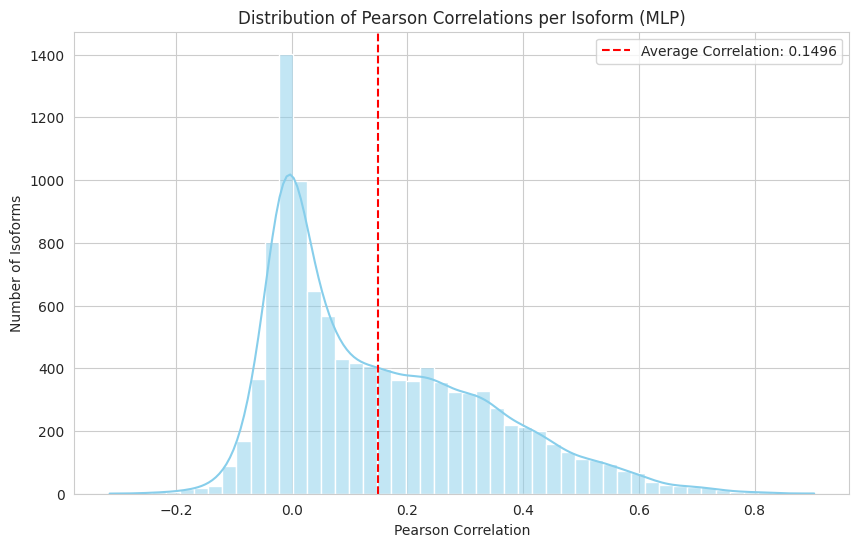

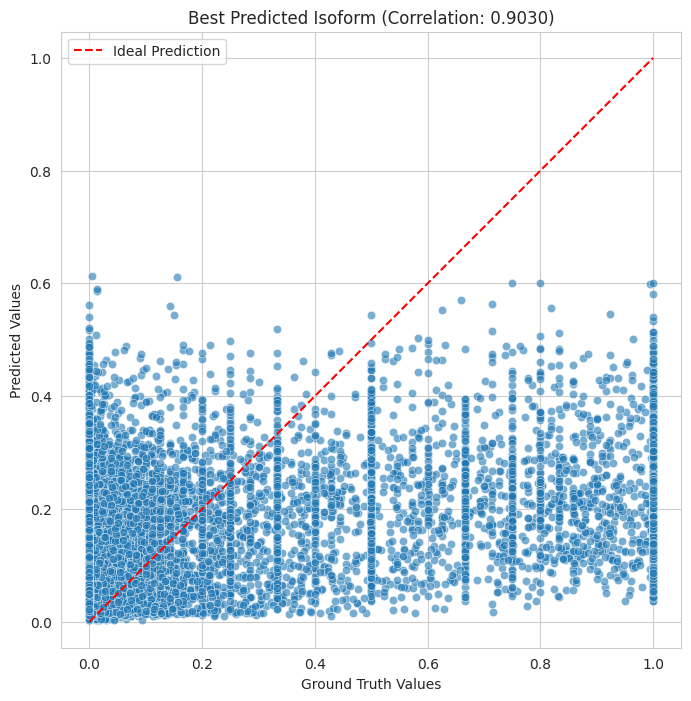

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Pearson Correlations
plt.figure(figsize=(10, 6))
sns.histplot(correlations, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Pearson Correlations per Isoform (MLP)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Number of Isoforms')
# Add a vertical line for the average correlation
plt.axvline(GeneAware_average_correlation, color='r', linestyle='--', label=f'Average Correlation: {GeneAware_average_correlation:.4f}')
plt.legend()
plt.show()

# Plot 2: Scatter plot for the best-predicted isoform
# Find the index of the isoform with the highest correlation
best_isoform_index = np.argmax(correlations)
best_corr = np.max(correlations)

# Get the prediction and ground truth values for this isoform
y_pred_best = GeneAware_predictions[:, best_isoform_index]
y_true_best = isoform_proportions[:, best_isoform_index].numpy().flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_best, y=y_pred_best, alpha=0.6)

# Add a 1:1 line for reference (ideal prediction)
max_val = max(y_true_best.max(), y_pred_best.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')

# plt.title(f'Best Predicted Isoform (Correlation: {best_corr:.4f})')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

A trend is slightly visible and accumulation in the ends of the plot might be indicative of the model learning the structure of the dataset.

# Testing PCA-trained MLP ✅
The same architecture was tested again after a PCA transformation on the gene abundances.

## Run Inference

In [10]:
checkpoint_path = RESULTS_PATH / "MLP_GeneAware_PCA" / "standardMLP_PCA_weights.pt"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Extract model configuration
config = checkpoint['config']
hidden_dims = config['hidden_dims']

# Load the PCA-transformed dataset
pca_genes_tensor, pca_isoform_proportions, pca_gene_to_iso_map, pca_iso_to_gene_index, pca_isoform_ids, gene_ids = load_standard_hvg(
    PT_PATH, 
    compute_pca=True)

# Instantiate the model with the same architecture as the saved model
MLP_PCA_model = MLP(
    input_dim=pca_genes_tensor.shape[1],
    out_dim=pca_isoform_proportions.shape[1],
    hidden_dims=hidden_dims
)

# Load the trained model weights
MLP_PCA_model.load_state_dict(checkpoint['model_state_dict'])

Computing PCA...


<All keys matched successfully>

In [11]:
# Set the model to evaluation mode
MLP_PCA_model.eval()

# Run the model on the PCA-transformed genes_tensor to get predictions
with torch.no_grad():
    MLP_PCA_predictions = MLP_PCA_model(pca_genes_tensor).numpy()

# Compute the Pearson correlation for each isoform
correlations = []
for i in range(pca_isoform_proportions.shape[1]):
    # Calculate correlation between the predicted and actual values for the i-th isoform
    corr, _ = pearsonr(MLP_PCA_predictions[:, i], pca_isoform_proportions[:, i])
    if not np.isnan(corr):
        correlations.append(corr)

# Calculate the average correlation
MLP_PCA_average_correlation = np.mean(correlations)

print(f"Average Pearson correlation (PCA-trained MLP): {MLP_PCA_average_correlation:.4f}")

Average Pearson correlation (PCA-trained MLP): 0.1599


## Plot

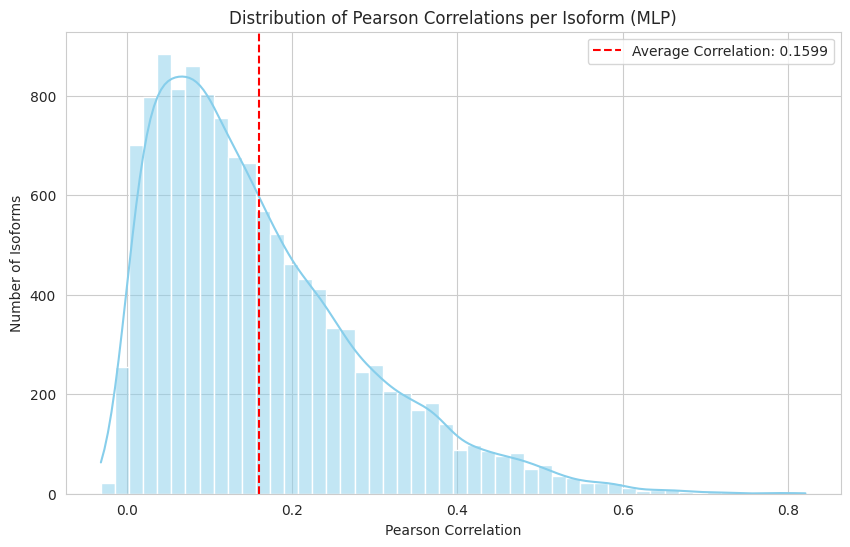

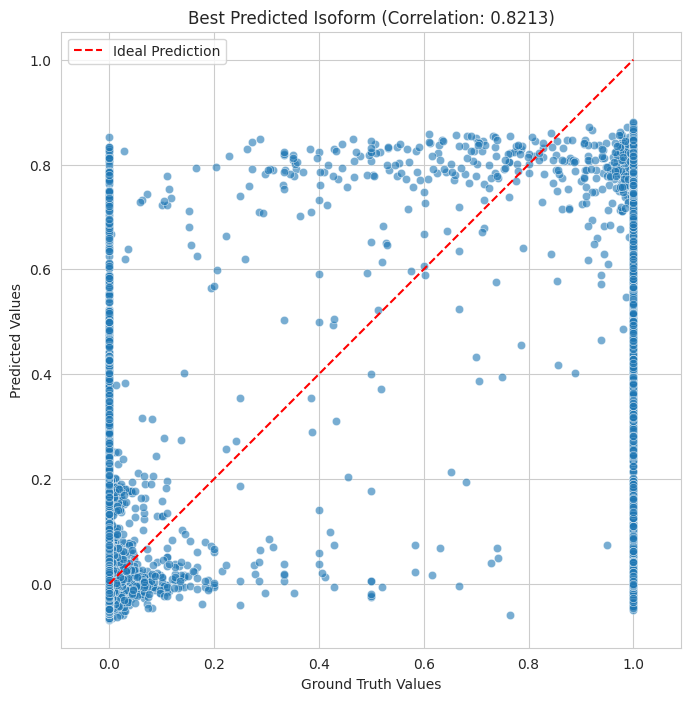

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Pearson Correlations
plt.figure(figsize=(10, 6))
sns.histplot(correlations, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Pearson Correlations per Isoform (MLP)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Number of Isoforms')
# Add a vertical line for the average correlation
plt.axvline(MLP_PCA_average_correlation, color='r', linestyle='--', label=f'Average Correlation: {MLP_PCA_average_correlation:.4f}')
plt.legend()
plt.show()

# Plot 2: Scatter plot for the best-predicted isoform
# Find the index of the isoform with the highest correlation
best_isoform_index = np.argmax(correlations)
best_corr = np.max(correlations)

# Get the prediction and ground truth values for this isoform
y_pred_best = MLP_PCA_predictions[:, best_isoform_index]
y_true_best = pca_isoform_proportions[:, best_isoform_index].numpy().flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_best, y=y_pred_best, alpha=0.6)

# Add a 1:1 line for reference (ideal prediction)
max_val = max(y_true_best.max(), y_pred_best.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

The accumulation in the corners of the data highlights a trend and possibly some improvement can be obtained with further training of the model.

# Testing MLP trained on scGPT ✅

## Inference

In [7]:
scGPT_PATH = Path("/dtu/blackhole/19/221977/train_val_split_data/scGPT_eval_embeddings.h5ad")
ISOFORM_PATH = Path("/dtu/blackhole/19/221977/train_val_split_data/sc_processed_transcripts_train_val_set.h5ad")

scGPT_genes_tensor, scGPT_isoform_tensor = load_scGPT(
        scGPT_PATH,
        ISOFORM_PATH,
        # max_samples=MAX_SAMPLES,
        # seed=SEED,
        compute_pca=False    
    )

Loading 18388 samples from /dtu/blackhole/19/221977/train_val_split_data/scGPT_eval_embeddings.h5ad...
Loading 18388 samples from /dtu/blackhole/19/221977/train_val_split_data/sc_processed_transcripts_train_val_set.h5ad...
Normalizing...


/dtu/blackhole/19/221977/scripts/data.py:348: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(X_norm)


In [8]:
checkpoint_path = RESULTS_PATH / "MLP_on_scGPT" / "scGPT_MLP" / "scGPT_MLP_weights.pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Extract model configuration
config = checkpoint['config']
hidden_dims = config['hidden_dims']

# Instantiate the model with the same architecture as the saved model
scGPT_model = MLP(
    input_dim=scGPT_genes_tensor.shape[1],
    out_dim=scGPT_isoform_tensor.shape[1],
    hidden_dims=hidden_dims
)

# Load the trained model weights
scGPT_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
# Set the model to evaluation mode
scGPT_model.eval()

# Run the model on the genes_data to get predictions
# Convert gene data to a PyTorch tensor
with torch.no_grad():
    scGPT_predictions = scGPT_model(scGPT_genes_tensor)

In [13]:
# scGPT_predictions_unlogged = torch.expm1(scGPT_predictions).cpu().numpy()
# targets_unlogged = torch.expm1(isoform_tensor).cpu().numpy()

# Compute the Pearson correlation for each isoform
scGPT_corr_list = []
for i in range(5000):
    # Calculate correlation between the predicted and actual values for the i-th isoform
    corr, _ = pearsonr(scGPT_predictions[:, i], scGPT_isoform_tensor[:, i])
    if not np.isnan(corr):
        scGPT_corr_list.append(corr)

In [15]:
# Calculate the average correlation
scGPT_average_correlation = np.mean(scGPT_corr_list)

## Plot

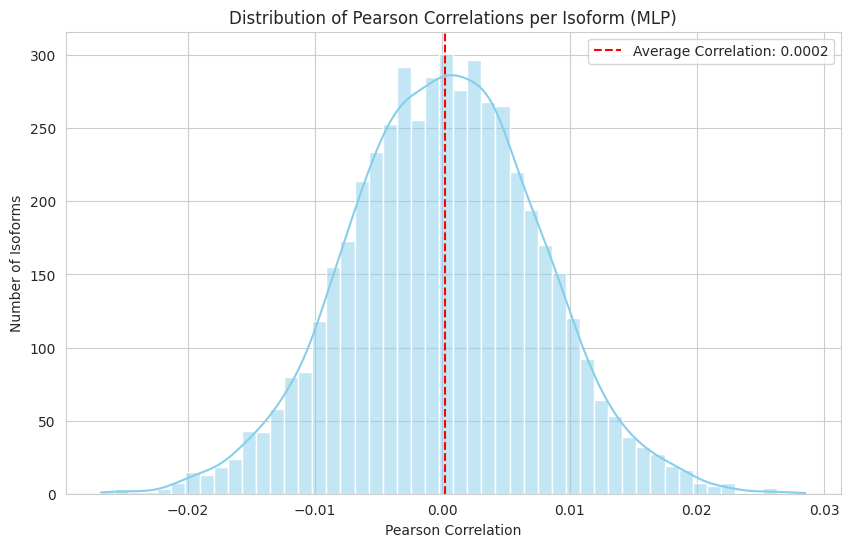

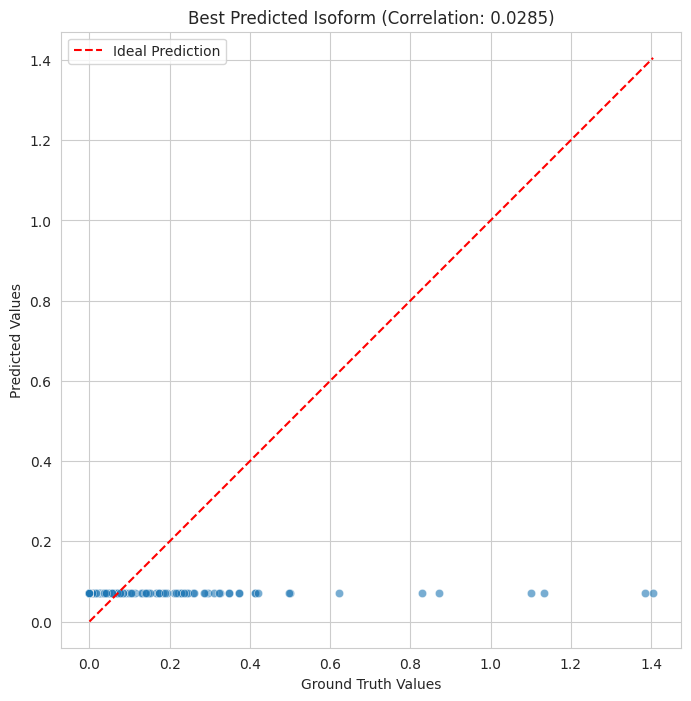

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Pearson Correlations
plt.figure(figsize=(10, 6))
sns.histplot(scGPT_corr_list, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Pearson Correlations per Isoform (MLP)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Number of Isoforms')
# Add a vertical line for the average correlation
plt.axvline(scGPT_average_correlation, color='r', linestyle='--', label=f'Average Correlation: {scGPT_average_correlation:.4f}')
plt.legend()
plt.show()

# Plot 2: Scatter plot for the best-predicted isoform
# Find the index of the isoform with the highest correlation
best_isoform_index = np.argmax(scGPT_corr_list)
best_corr = np.max(scGPT_corr_list)

# Get the prediction and ground truth values for this isoform
y_pred_best = scGPT_predictions[:, best_isoform_index]
y_true_best = isoform_tensor[:, best_isoform_index].numpy().flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_best, y=y_pred_best, alpha=0.6)

# Add a 1:1 line for reference (ideal prediction)
max_val = max(y_true_best.max(), y_pred_best.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')

plt.title(f'Best Predicted Isoform (Correlation: {best_corr:.4f})')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

The poor performance of this method is likely due to the scGPT embeddings' widely different order of magnitude with respect to the isoform proportions to which they are compared to.

# LSTM

## Inference

In [3]:
iso_to_gene_idx = torch.from_numpy(iso_to_gene).long()

In [59]:
checkpoint_path = RESULTS_PATH / "LSTM_20epochs" / "lstm_isoformer_weights.pt"
LSTM_model = LSTMIsoformer(
        input_dim=genes_t.shape[1],
        isoform_dim=iso_t.shape[1],
        gene_index_per_iso=iso_to_gene_idx,
        hidden_dim=256,
        num_layers=2,
        dropout=0.3,
        bidirectional=True,  
    ).to('cuda')
LSTM_model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [35]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LSTM_model = LSTM_model.to(device).eval()

batch_size = 128
outputs = []
with torch.no_grad():
    for i in range(0, genes_t.shape[0], batch_size):
        batch = genes_t[i:i+batch_size].to(device)
        outputs.append(LSTM_model(batch).cpu())
LSTM_predictions = torch.cat(outputs, dim=0)  # shape: (n_cells, isoforms)


In [62]:
# scGPT_predictions_unlogged = torch.expm1(scGPT_predictions).cpu().numpy()
# targets_unlogged = torch.expm1(isoform_tensor).cpu().numpy()

# Compute the Pearson correlation for each isoform
LSTM_corr_list = []
for i in range(5000):
    # Calculate correlation between the predicted and actual values for the i-th isoform
    corr, _ = pearsonr(LSTM_predictions[:, i].cpu(), standard_hvg_isoform_proportions[:, i].cpu())
    if not np.isnan(corr):
        LSTM_corr_list.append(corr)

/tmp/ipykernel_136275/2936635243.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(LSTM_predictions[:, i].cpu(), standard_hvg_isoform_proportions[:, i].cpu())


In [63]:
# Calculate the average correlation
LSTM_average_correlation = np.mean(LSTM_corr_list)

## Plot

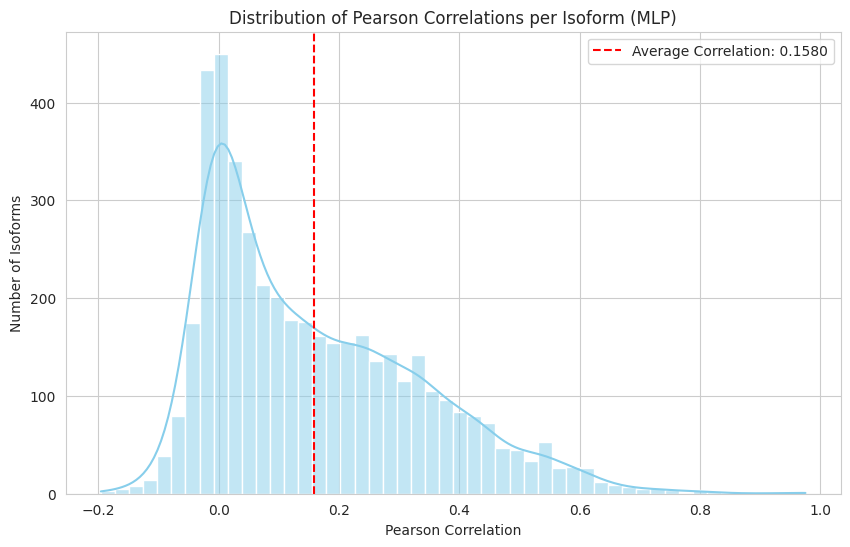

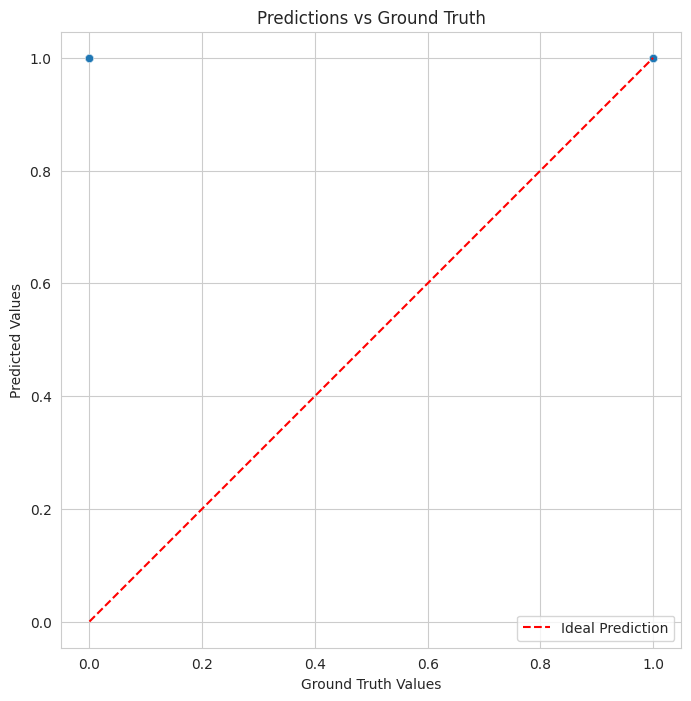

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Pearson Correlations
plt.figure(figsize=(10, 6))
sns.histplot(LSTM_corr_list, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Pearson Correlations per Isoform (MLP)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Number of Isoforms')
# Add a vertical line for the average correlation
plt.axvline(LSTM_average_correlation, color='r', linestyle='--', label=f'Average Correlation: {LSTM_average_correlation:.4f}')
plt.legend()
plt.show()

# Plot 2: Scatter plot for the best-predicted isoform
# Find the index of the isoform with the highest correlation
best_isoform_index = np.argmax(LSTM_corr_list)
best_corr = np.max(LSTM_corr_list)

# Get the prediction and ground truth values for this isoform
y_pred_best = LSTM_predictions[:, best_isoform_index]
y_true_best = standard_hvg_isoform_proportions[:, best_isoform_index].numpy().flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_best, y=y_pred_best, alpha=0.6)

# Add a 1:1 line for reference (ideal prediction)
max_val = max(y_true_best.max(), y_pred_best.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')

plt.title('Predictions vs Ground Truth')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Custom VAE Embeddings ✅

## Embeddings
A custom VAE model was trained on the input dataset and used to retrieve representations of each observation. The MLP architecture was trained on these embeddings and tested with the held out portion of the data.

## Inference

In [69]:
checkpoint_path = RESULTS_PATH / "MLP_VAE" / "MLP_VAE_weights.pt"
checkpoint = torch.load(checkpoint_path, weights_only=False)

In [70]:
# Extract model configuration
config = checkpoint['config']
hidden_dims = config['hidden_dims']
VAE_TRAIN_EMB_PATH = Path("/zhome/af/a/221977/Blackhole/train_val_split_data/vae_latent_embeddings_preprocessed_test.pt")

Z, emb_stats = load_embeddings(
    VAE_TRAIN_EMB_PATH, 
    standardize=True
)

In [72]:
MLP_VAE_model = GeneAwareMLP(
        input_dim=Z.shape[1],
        hidden_dims=config['hidden_dims'],
        isoform_dim=iso_t.shape[1],
        gene_index_per_iso=torch.from_numpy(iso_to_gene_idx.numpy()),  # Pass tensor
        dropout=config['dropout'],
    )
print(f"\nModel parameters: {sum(p.numel() for p in MLP_VAE_model.parameters())/1e6:.2f}M")

MLP_VAE_model.load_state_dict(checkpoint['model_state_dict'])


Model parameters: 2.82M


<All keys matched successfully>

In [73]:
MLP_VAE_model.eval()
with torch.no_grad():
    MLP_VAE_predictions = MLP_VAE_model(Z).numpy()

In [76]:
# Compute the Pearson correlation for each isoform
MLP_VAE_correlations = []
for i in range(2000):
    # Calculate correlation between the predicted and actual values for the i-th isoform
    corr, _ = pearsonr(MLP_VAE_predictions[:, i], iso_t[:, i])
    if not np.isnan(corr):
        MLP_VAE_correlations.append(corr)

# Calculate the average correlation
MLP_VAE_average_correlation = np.mean(MLP_VAE_correlations)

print(f"Average Pearson correlation: {MLP_VAE_average_correlation:.4f}")

/tmp/ipykernel_136275/2367656353.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(MLP_VAE_predictions[:, i], iso_t[:, i])


Average Pearson correlation: 0.1445


Plotting the correlation achieved by the model

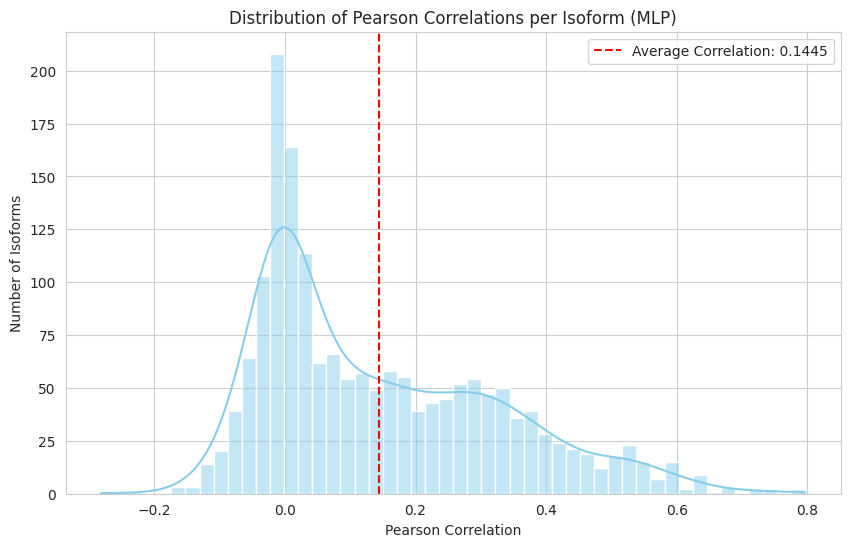

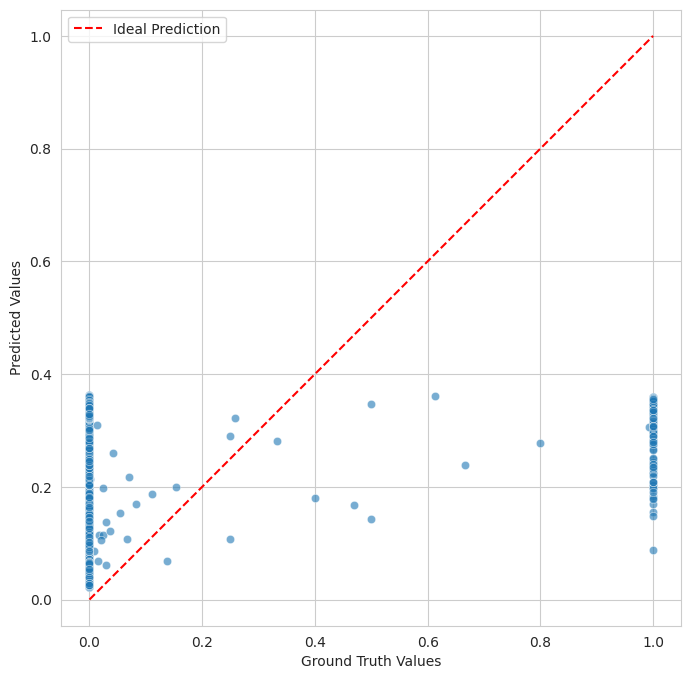

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Pearson Correlations
plt.figure(figsize=(10, 6))
sns.histplot(MLP_VAE_correlations, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Pearson Correlations per Isoform (MLP)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Number of Isoforms')
# Add a vertical line for the average correlation
plt.axvline(MLP_VAE_average_correlation, color='r', linestyle='--', label=f'Average Correlation: {MLP_VAE_average_correlation:.4f}')
plt.legend()
plt.show()

# Plot 2: Scatter plot for the best-predicted isoform
# Find the index of the isoform with the highest correlation
best_isoform_index = np.argmax(MLP_VAE_correlations)
best_corr = np.max(MLP_VAE_correlations)

# Get the prediction and ground truth values for this isoform
y_pred_best = MLP_VAE_predictions[:, best_isoform_index]
y_true_best = iso_t[:, best_isoform_index].numpy().flatten()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_best, y=y_pred_best, alpha=0.6)

# Add a 1:1 line for reference (ideal prediction)
max_val = max(y_true_best.max(), y_pred_best.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

The performance of this specific MLP, combined with the evaluation of the VAE itself that generated its input data, suggests a limited ability of the model to predict the target variable accurately, as evidenced by the low average Pearson Correlation and the scattered distribution of data points in the prediction plot.